In [2]:
# ## 1. Load and Preprocess Burglary Data

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data and aggregate to ward-monthly counts
burglary = pd.read_csv('data/residential_burglary.csv')

# Combine 'Year' and 'Month' into a single datetime column
burglary ["Month"] = pd.to_datetime(burglary ["Year"].astype(str) + "-" + burglary ["Month"].astype(str), format="%Y-%m")

burglary_monthly = burglary.groupby(["Ward Code", "Month"]).size().reset_index(name="Count")

print("Raw data overview:")
print(f"Total wards: {burglary_monthly['Ward Code'].nunique()}")
print(f"Time range: {burglary_monthly['Month'].min()} to {burglary_monthly['Month'].max()}")

burglary_monthly

Raw data overview:
Total wards: 679
Time range: 2013-12-01 00:00:00 to 2025-02-01 00:00:00


,Ward Code,Month,Count
0,E05009317,2013-12-01,8
1,E05009317,2014-01-01,23
2,E05009317,2014-02-01,12
3,E05009317,2014-03-01,11
4,E05009317,2014-04-01,21
...,...,...,...
89633,E05014119,2024-10-01,1
89634,E05014119,2024-11-01,2
89635,E05014119,2024-12-01,4
89636,E05014119,2025-01-01,3


In [5]:

# Load and prepare car ownership data
cars_df = pd.read_excel('data/housing/cars_or_vans_wards.xlsx', sheet_name='2021')
cars_df['NoCarPct'] = cars_df['none'] / cars_df['All households']
static_features = cars_df[['ward code', 'NoCarPct']].rename(columns={'ward code': 'Ward Code'})

# Merge static features with burglary data
burglary_enriched = pd.merge(burglary_monthly, static_features, on='Ward Code', how='inner')

burglary_enriched
# print(f"Wards with available socio-economic data: {burglary_enriched['Ward Code'].nunique()}")

,Ward Code,Month,Count,NoCarPct
0,E05009317,2013-12-01,8,0.632145
1,E05009317,2014-01-01,23,0.632145
2,E05009317,2014-02-01,12,0.632145
3,E05009317,2014-03-01,11,0.632145
4,E05009317,2014-04-01,21,0.632145
...,...,...,...,...
89633,E05014119,2024-10-01,1,0.424795
89634,E05014119,2024-11-01,2,0.424795
89635,E05014119,2024-12-01,4,0.424795
89636,E05014119,2025-01-01,3,0.424795


In [6]:
## 4. Modified SARIMAX Implementation with Exogenous Variables

import warnings

warnings.filterwarnings("ignore")

# Set manual orders for all wards
UNIVERSAL_ORDER = (3, 1, 1)
SEASONAL_ORDER = (3, 1, 1, 12)  # Monthly seasonality
TEST_MONTHS = 26

def analyze_ward_exog(args):
    """Process a ward with SARIMAX and exogenous features"""
    ward_code, ward_df = args
    try:
        # Filter wards with sufficient history
        if len(ward_df) < TEST_MONTHS * 2:
            print(f"{ward_code} has less than {TEST_MONTHS} months data")
            return None

        # Prepare data with exogenous variable
        ward_df = ward_df.set_index('Month').asfreq('MS')

        if ward_df.isnull().values.any():
            print(f"{ward_code} has NaN values")
            if ward_df["Count"].isnull().sum().sum() > 10:
                print(f"{ward_code} has more than 10 NaN values, aborted")
                return None
            ward_df.ffill(inplace=True)

        exog = ward_df[['NoCarPct']]  # Static feature repeated for all time points
        # Ensure exog does not contain NaN or infinite values
        if exog.isnull().values.any() or np.isinf(exog.values).any():
            print(f"{ward_code} has NaN or infinite values in exog")
            # Fill NaN or infinite values with the previous valid value
            exog.replace([np.inf, -np.inf], np.nan, inplace=True)
            exog.ffill(inplace=True)

        # Split data (keep exogenous aligned)
        train = ward_df.iloc[:-TEST_MONTHS]
        test = ward_df.iloc[-TEST_MONTHS:]
        exog_train = exog.iloc[:-TEST_MONTHS]
        exog_test = exog.iloc[-TEST_MONTHS:]

        # Fit pure SARIMAX model:
        model = SARIMAX(train['Count'],
                        order=UNIVERSAL_ORDER,
                        seasonal_order=SEASONAL_ORDER,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)

        # Fit SARIMAX with exogenous variable
        expog_model = SARIMAX(train['Count'],
                        exog=exog_train,
                        order=UNIVERSAL_ORDER,
                        seasonal_order=SEASONAL_ORDER,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results_expog = expog_model.fit(disp=False)

        # Forecast with future exogenous values
        forecast = results.get_forecast(steps=TEST_MONTHS)
        forecast_expog = results_expog.get_forecast(steps=TEST_MONTHS, exog=exog_test)

        print(f"{ward_code} completed")

        return {
            'ward_code': ward_code,
            'model': results,
            'actual': test['Count'].values,
            'predicted': forecast.predicted_mean.values,
            'expog_predicted': forecast_expog.predicted_mean.values,
            'exog_coef': results_expog.params['NoCarPct'],  # Store feature coefficient
            'conf_int': forecast.conf_int().values,
            'conf_int_exog': forecast_expog.conf_int().values
        }
    except Exception as e:
        print(f"Error processing {ward_code}: {str(e)}")
        return None

# Process all wards
exog_results = []
for ward_code, group in burglary_enriched.groupby('Ward Code'):
    analysis = analyze_ward_exog((ward_code, group))
    if analysis:
        exog_results.append(analysis)

warnings.filterwarnings("default")

E05009317 completed
E05009318 completed
E05009319 completed
E05009320 completed
E05009321 has NaN values
E05009321 completed
E05009322 completed
E05009323 completed
E05009324 has NaN values
E05009324 completed
E05009325 completed
E05009326 has NaN values
E05009326 has more than 10 NaN values, aborted
E05009327 completed
E05009328 has NaN values
E05009328 has more than 10 NaN values, aborted
E05009329 completed
E05009330 completed
E05009331 completed
E05009332 completed
E05009333 completed
E05009334 completed
E05009335 completed
E05009336 completed
E05009367 has NaN values
E05009367 completed
E05009368 has NaN values
E05009368 completed
E05009369 completed
E05009370 completed
E05009371 completed
E05009372 completed
E05009373 completed
E05009374 completed
E05009375 completed
E05009376 completed
E05009377 completed
E05009378 completed
E05009379 completed
E05009380 completed
E05009381 completed
E05009382 completed
E05009383 completed
E05009384 has NaN values
E05009384 completed
E05009385 c

In [7]:
# 4. Performance Comparison Analysis

def calculate_metrics(actual, pred):
    """Calculate key performance metrics"""
    return {
        'mae': mean_absolute_error(actual, pred),
        'rmse': np.sqrt(mean_squared_error(actual, pred)),
        'mape': np.mean(np.abs((actual - pred) / actual)) * 100
    }

# Calculate metrics for both models, ensuring no NaN values
comparison_results = []
for res in exog_results:
    if np.isnan(res['actual']).any() or np.isnan(res['predicted']).any() or np.isnan(res['expog_predicted']).any():
        print(f"Skipping ward {res['ward_code']} due to NaN values")
        continue  # Skip this ward

    base_metrics = calculate_metrics(res['actual'], res['predicted'])
    exog_metrics = calculate_metrics(res['actual'], res['expog_predicted'])

    comparison_results.append({
        'ward': res['ward_code'],
        'base_mae': base_metrics['mae'],
        'exog_mae': exog_metrics['mae'],
        'base_rmse': base_metrics['rmse'],
        'exog_rmse': exog_metrics['rmse'],
        'mae_improvement': base_metrics['mae'] - exog_metrics['mae'],
        'rmse_improvement': base_metrics['rmse'] - exog_metrics['rmse'],
        'exog_coef': res['exog_coef']
    })

comp_df = pd.DataFrame(comparison_results)


In [8]:
# ## 5. Statistical Validation

print("\nOverall Performance Comparison:")
print(f"Average MAE Improvement: {comp_df['mae_improvement'].mean():.2f}")
print(f"Average RMSE Improvement: {comp_df['rmse_improvement'].mean():.2f}")
print(f"Percentage of Wards with Improvement: {np.mean(comp_df['mae_improvement'] > 0)*100:.1f}%")

# Statistical significance test
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(comp_df['base_mae'], comp_df['exog_mae'])
print(f"\nPaired t-test Results (MAE): t={t_stat:.2f}, p={p_value:.4f}")


Overall Performance Comparison:
Average MAE Improvement: 0.00
Average RMSE Improvement: 0.00
Percentage of Wards with Improvement: 50.2%

Paired t-test Results (MAE): t=1.18, p=0.2394


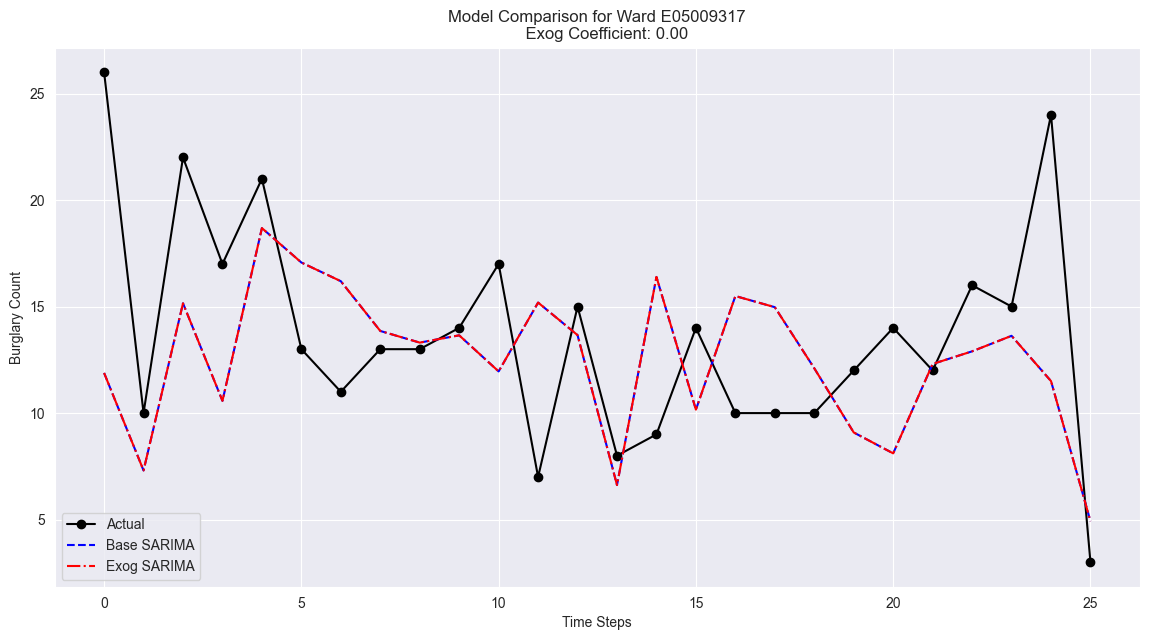

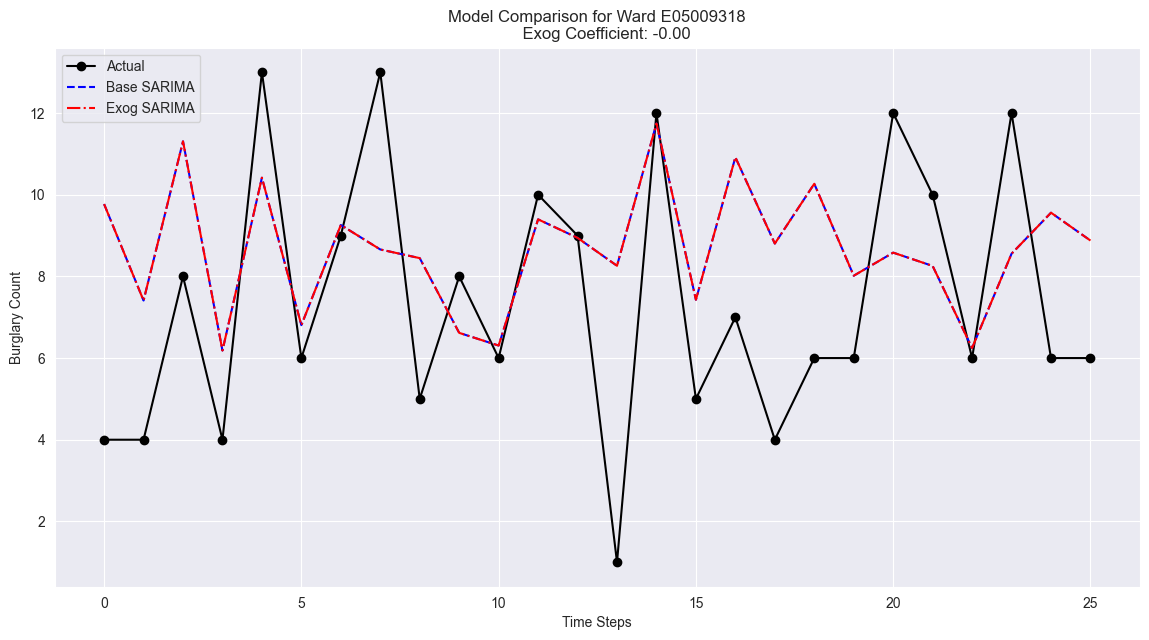

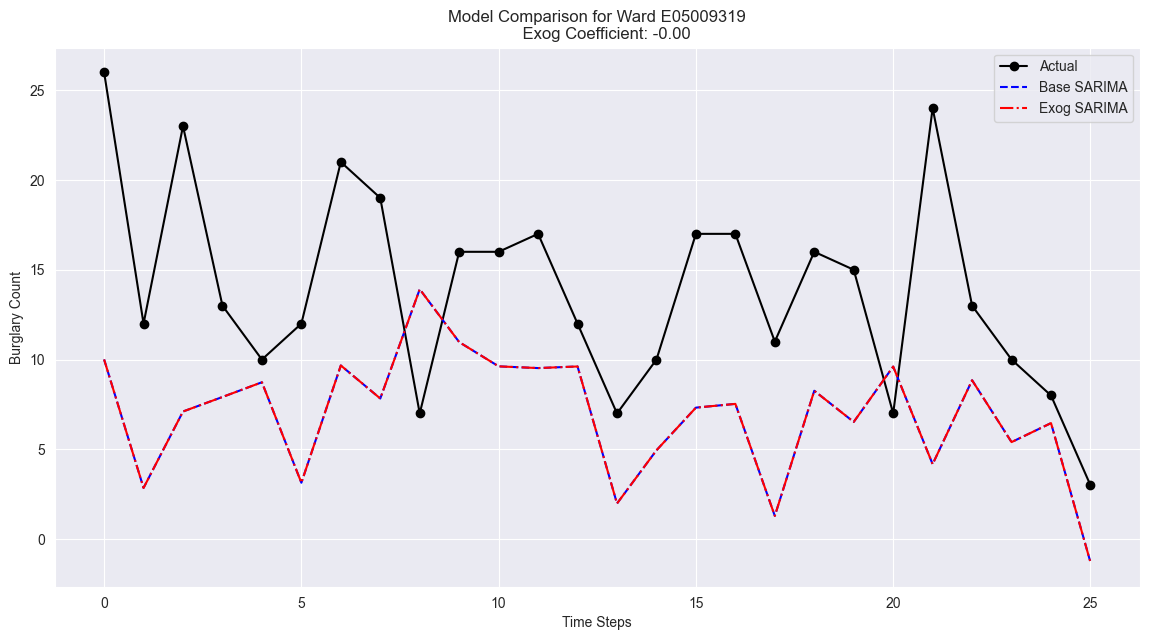

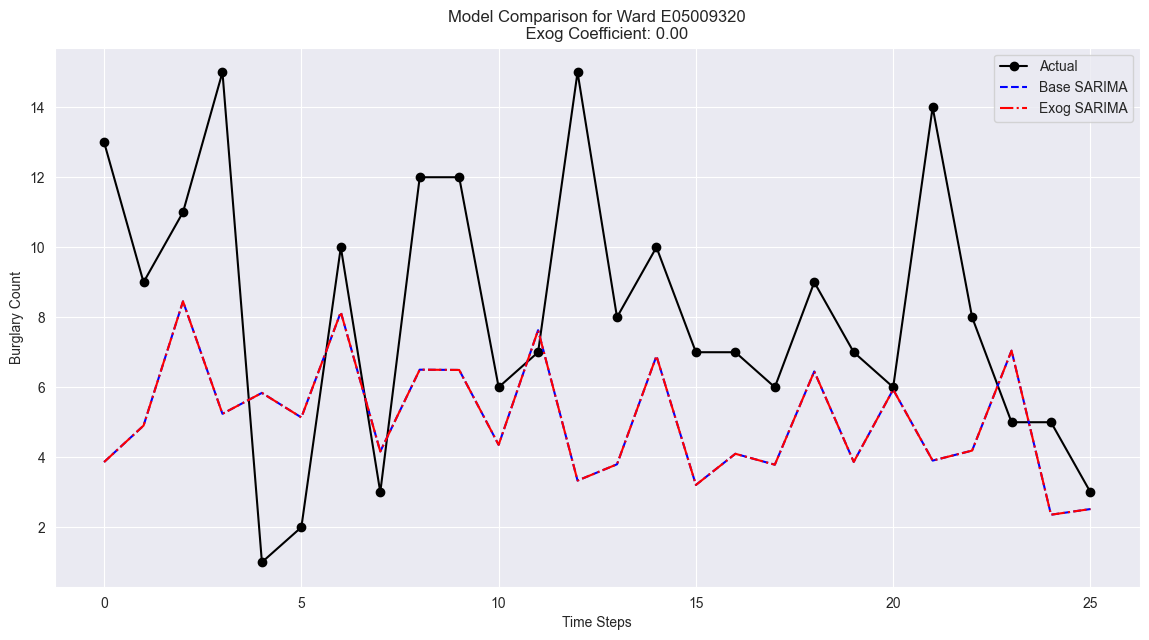

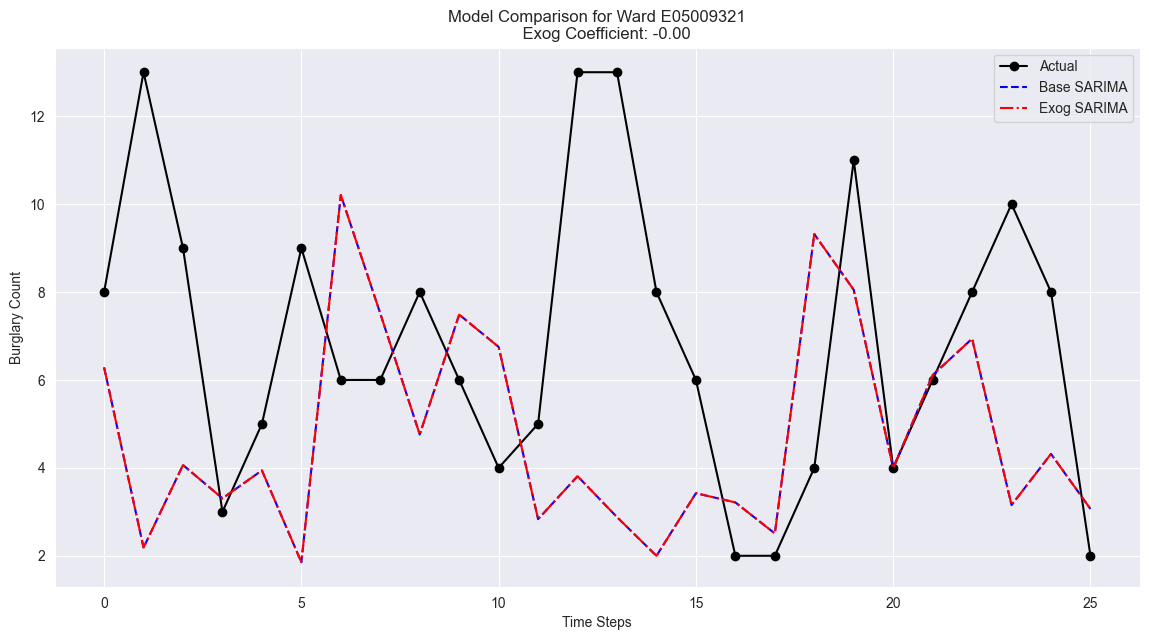

In [9]:
# ## 6. Visualization Suite

def plot_model_comparison(result):
    """Visual comparison of both models' predictions"""
    plt.figure(figsize=(14, 7))

    # Create time axis
    time_steps = np.arange(len(result['actual']))

    # Plot actual vs predictions
    plt.plot(time_steps, result['actual'], 'ko-', label='Actual')
    plt.plot(time_steps, result['predicted'], 'b--', label='Base SARIMA')
    plt.plot(time_steps, result['expog_predicted'], 'r-.', label='Exog SARIMA')

    # Formatting
    plt.title(f'''Model Comparison for Ward {result['ward_code']}
    Exog Coefficient: {result['exog_coef']:.2f}''')
    plt.xlabel('Time Steps')
    plt.ylabel('Burglary Count')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot first 5 wards
for res in exog_results[:5]:
    plot_model_comparison(res)